# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [94]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Disable the specific warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Load Feature File
df = pd.read_csv("../TeamSeasons.csv")

## Basic Seed Exploration

In [53]:
tourney_teams = df[df['Seed'].notna()]

In [82]:
round_num_map = {
    np.nan: 0,
    "Play In": 0,
    "First Round": 1,
    "Second Round": 2,
    "Sweet Sixteen": 3,
    "Elite Eight": 4,
    "Final Four": 5,
    "Championship": 6,
    "Champion": 7
}
scaled_round_num = {k: v/7 for k, v in round_num_map.items()}
tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)
tourney_teams["ScaledExitRoundNum"] = tourney_teams["ExitRound"].map(scaled_round_num)


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/1123767301.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)
/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/1123767301.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_teams["ScaledExitRoundNum"] = tourney_teams["ExitRound"].map(scaled_round_num)


In [55]:
(5 + 5 + 6 + 7) / 4

5.75

In [56]:
seed_exp_perf = {
    1: 5.75, # Two lose the final four, one lose in championship, one win the championship
    2: 4, # Make the Elite Eight
    3: 3, 4: 3, # Make the Sweet Sixteen
    5: 2, 6: 2, 7: 2, 8: 2, # Make the Second Round
    9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1 # Lose the First Round
}
seed_historical_perf = {}

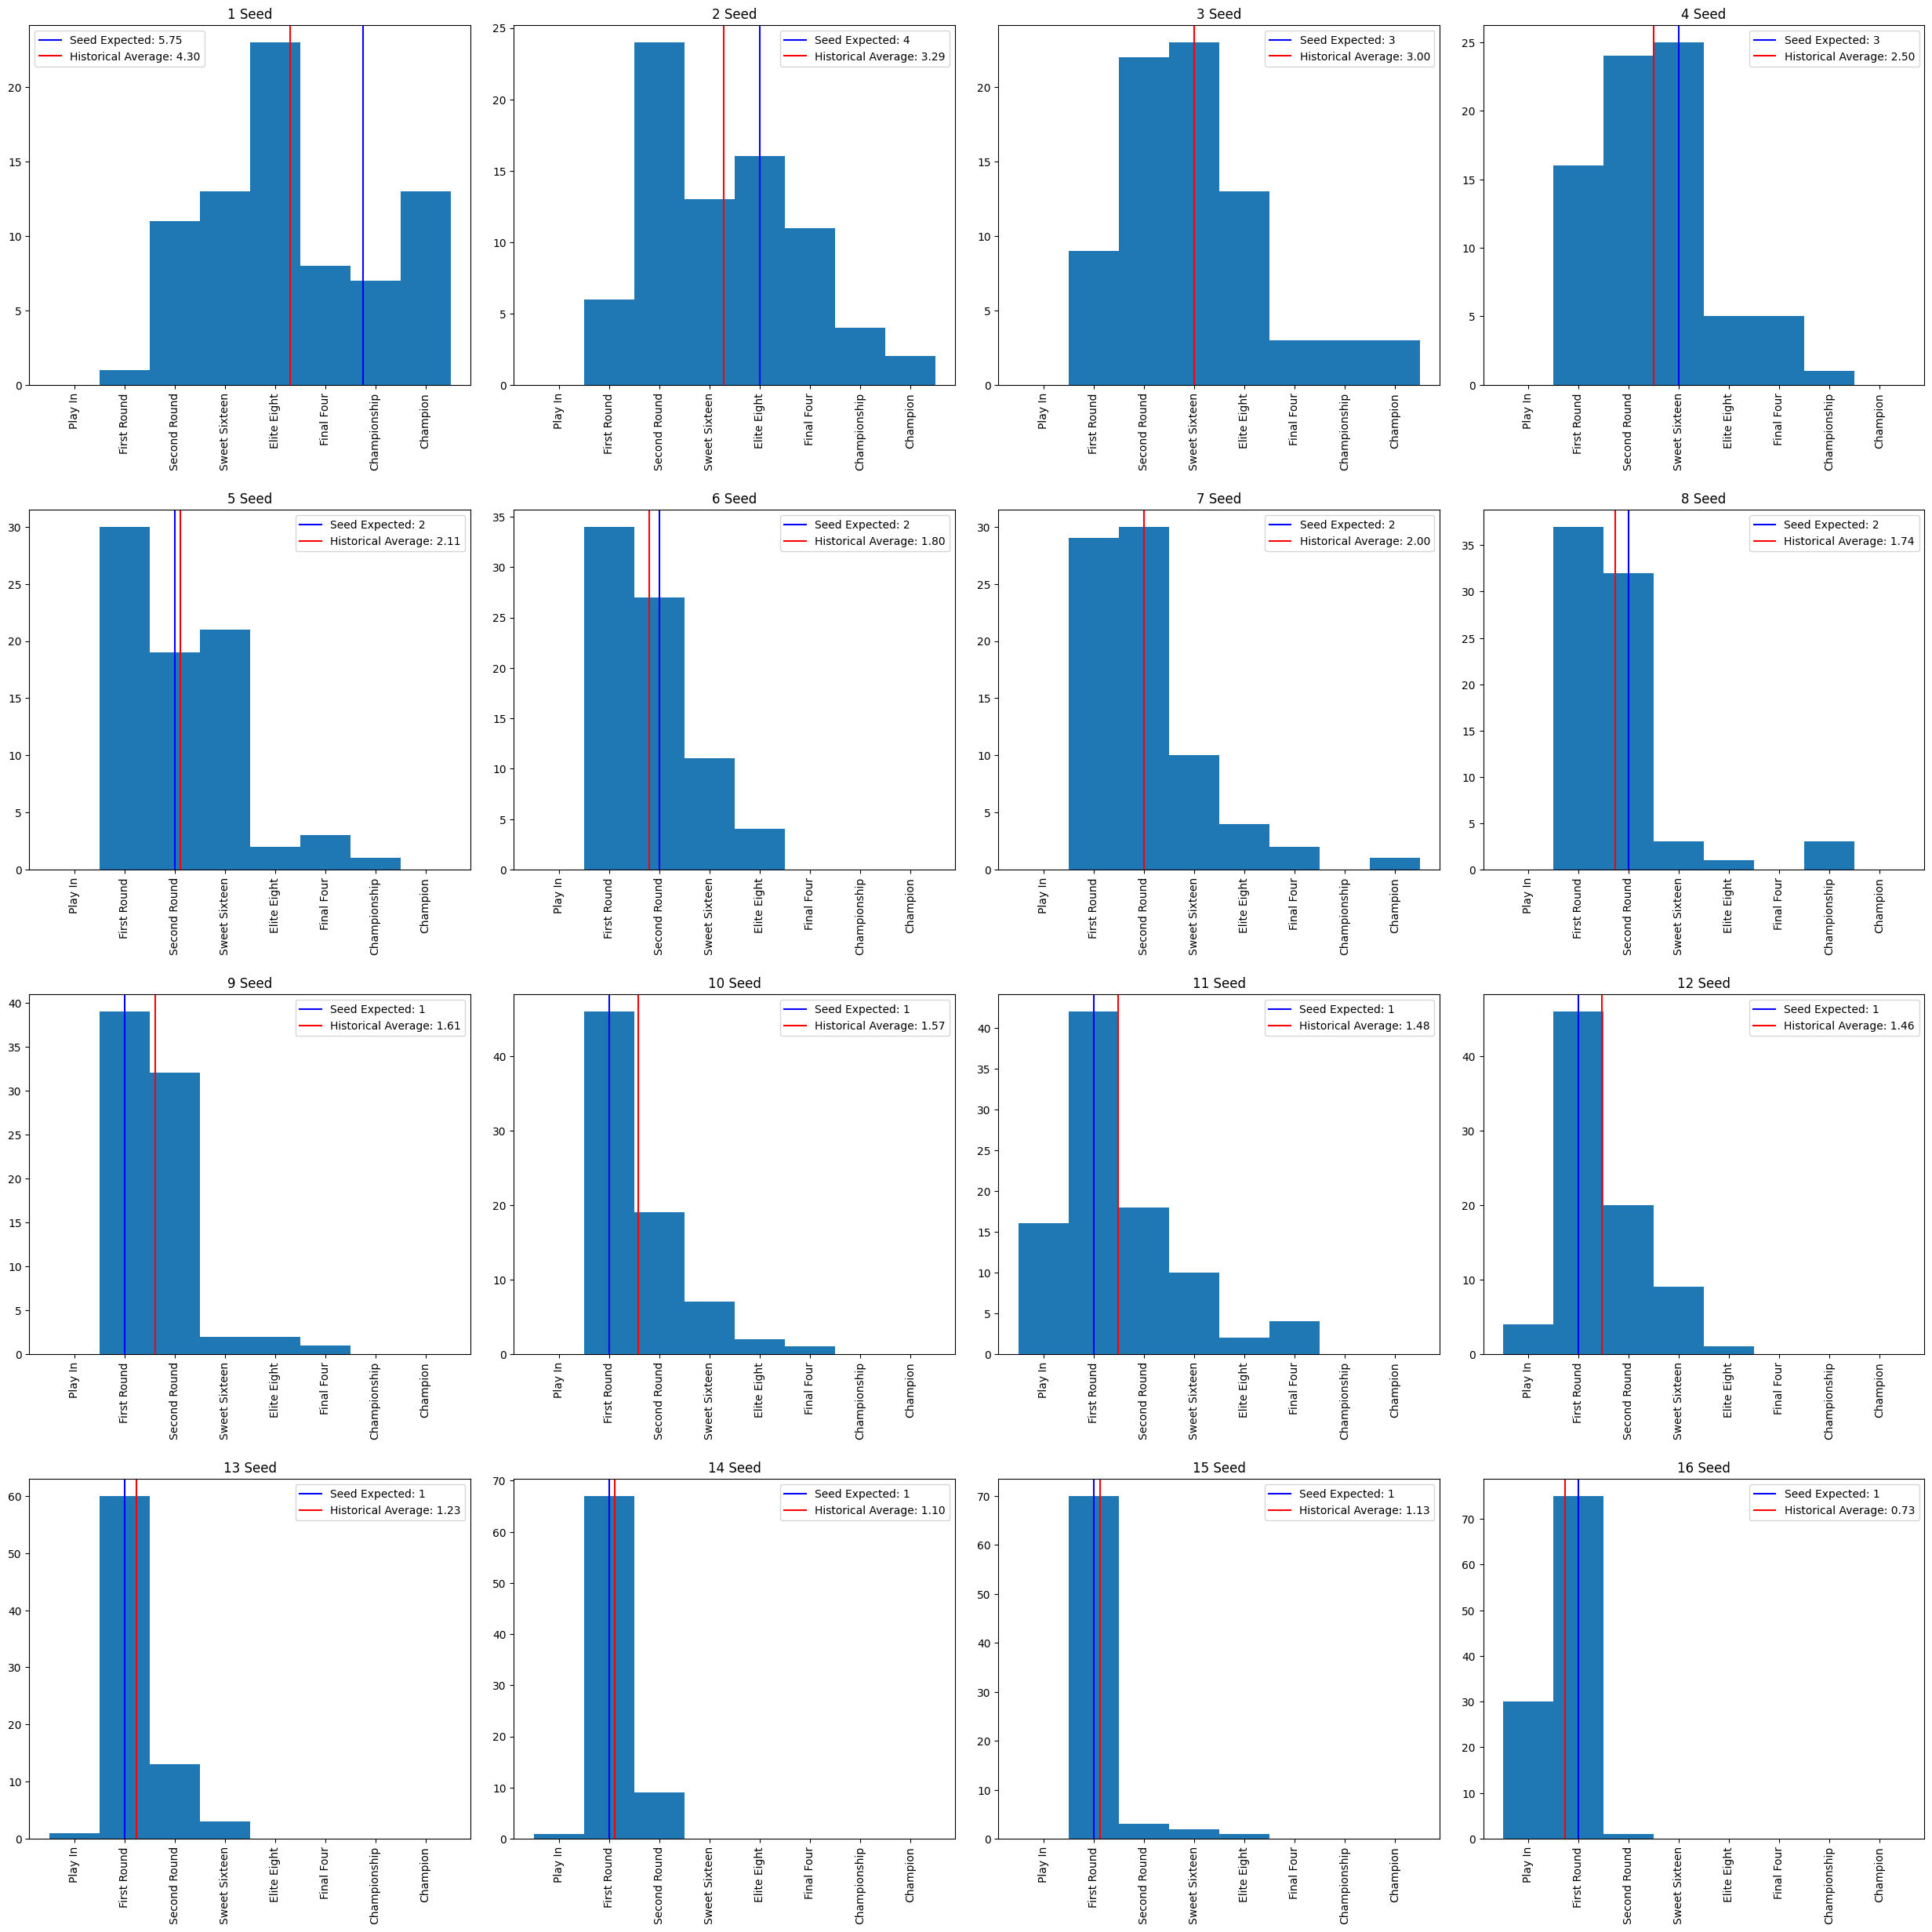

In [57]:
BIN_OFFSET = 0.5
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
ax = ax.flatten()
for seed, seed_df in tourney_teams[["ExitRound", "Seed", "ExitRoundNum"]].groupby("Seed"):
    seed_axis = ax[int(seed) - 1]
    seed_df = seed_df.sort_values(["ExitRoundNum"])
    n, bins, patches = seed_axis.hist(seed_df["ExitRoundNum"], bins=range(0, 9))
    hist_avg = sum([count * rnd for count, rnd in zip(n, bins)]) / sum(n)
    seed_historical_perf[int(seed)] = hist_avg       
    seed_axis.set_title(f"{int(seed)} Seed")
    seed_axis.axvline(x = seed_exp_perf[int(seed)] + BIN_OFFSET, color = 'b', label = f'Seed Expected: {seed_exp_perf[int(seed)]}')
    seed_axis.axvline(x = hist_avg + BIN_OFFSET, color = 'r', label = f'Historical Average: {hist_avg:.2f}')
    seed_axis.set_xticks(ticks = [p._x0 + BIN_OFFSET for p in patches], labels = round_num_map.keys(), rotation=90)
    seed_axis.legend()
fig.tight_layout(pad = 2)
plt.show()

In [95]:
tourney_teams["ExceedExp"] = tourney_teams["ExitRoundNum"] > tourney_teams["Seed"].map(seed_exp_perf)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


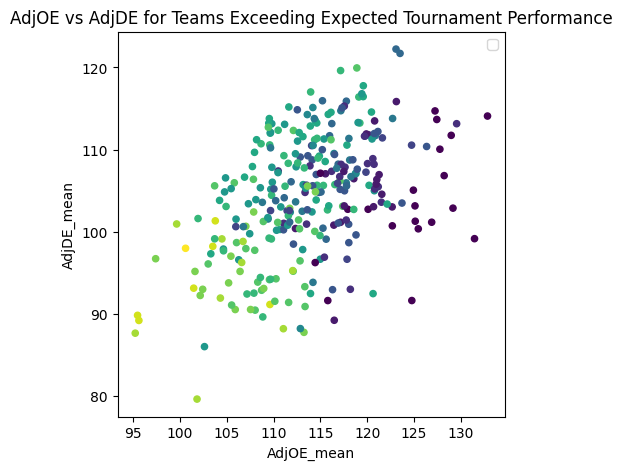

In [105]:
exceed_exp_df = tourney_teams[tourney_teams["ExceedExp"]]
# Color by seed
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(1, 16)
exceed_exp_df["color"] = exceed_exp_df["Seed"].apply(lambda x: cmap(norm(x)))
exceed_exp_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c='color', figsize=(5, 5))
plt.title("AdjOE vs AdjDE for Teams Exceeding Expected Tournament Performance")
plt.legend()
plt.show()

# Train a basic logistic regression

In [97]:
tourney_teams["ExceedExp"].value_counts()

False    970
True     298
Name: ExceedExp, dtype: int64

In [128]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = tourney_teams[["AdjOE_mean", "AdjDE_mean", "AdjNE_mean", "Poss_mean", "FG3%_mean", "FT%_mean", "TO_mean", "Q1_WinPct", "Q2_WinPct", "Q3_WinPct", "Q4_WinPct"]]
X.fillna(0, inplace=True)
Y = tourney_teams["ExceedExp"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size=0.25, random_state=42, stratify=Y)
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

In [129]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

models = {
    "Logistic Reg": LogisticRegression(),
    "Ridge": RidgeClassifier(alpha=0.5),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel="poly", degree=3, C=0.1, gamma="auto"),
    "LinearSVC": LinearSVC(max_iter=100000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}
model_res = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall"])
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    model_res = model_res.append({
        "Model": model_name,
        "Accuracy":  accuracy_score(predictions, Y_test),
        "Precision": precision_score(predictions, Y_test),
        "Recall":    recall_score(predictions, Y_test, zero_division="warn")
    }, ignore_index=True)
print(model_res)


/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           Model  Accuracy  Precision    Recall
0   Logistic Reg  0.766562   0.000000  0.000000
1          Ridge  0.766562   0.000000  0.000000
2  Random Forest  0.747634   0.000000  0.000000
3            SVM  0.763407   0.000000  0.000000
4      LinearSVC  0.766562   0.000000  0.000000
5    Naive Bayes  0.580442   0.297297  0.213592
6            KNN  0.728707   0.121622  0.300000
7  Decision Tree  0.640379   0.337838  0.277778
8        XGBoost  0.728707   0.229730  0.369565


/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Naive Bayes Feature Importance

In [130]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(models["Naive Bayes"], X_test, Y_test)

nb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": imps.importances_mean,
    "Std": imps.importances_std
})
nb_importances = nb_importances.sort_values("Importance", ascending=False)
nb_importances

,Feature,Importance,Std
3,Poss_mean,0.002524,0.006434
4,FG3%_mean,-0.007571,0.005126
2,AdjNE_mean,-0.013249,0.006434
5,FT%_mean,-0.016404,0.012681
9,Q3_WinPct,-0.025237,0.009976
10,Q4_WinPct,-0.029653,0.007358
6,TO_mean,-0.030284,0.011904
1,AdjDE_mean,-0.032808,0.015785
0,AdjOE_mean,-0.034069,0.010055
8,Q2_WinPct,-0.035331,0.010632


## Looking at XGB Boost Feature Importance

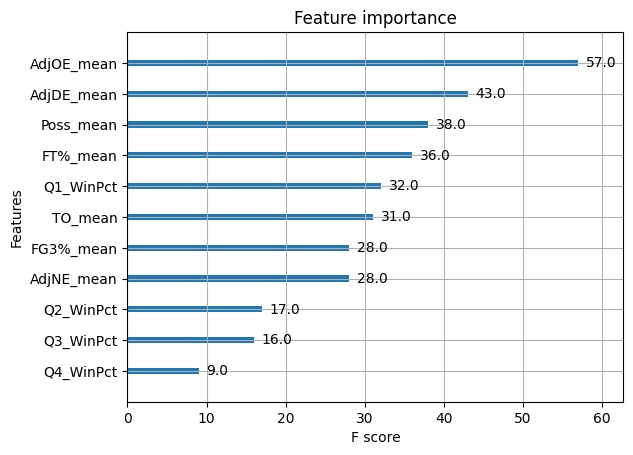

In [131]:
# XGBoost Feature Importance
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=X.columns.tolist())
xgb.plot_importance(xgb.train({}, dtrain))
plt.show()

# Predicting Exit Round with Different Basic Regression Models

In [132]:
# Scale features per column
X_scaled = StandardScaler().fit_transform(X)
# ScaledExitRoundNum
Y_sern = tourney_teams["ScaledExitRoundNum"]


In [133]:
# Predict ExitRoundNum with XGBoost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

reg_models = [
    ("XGBReg", XGBRegressor()),
    ("linear", LinearRegression()),
    ("SGD", SGDRegressor())
]
reg_model_res = pd.DataFrame(columns=["Model", "MAE", "MAE_std"])
for model_name, model in reg_models:
    score = cross_val_score(model, X_scaled, Y_sern, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
    reg_model_res = reg_model_res.append({
        "Model": model_name,
        "MAE": score.mean(),
        "MAE_std": score.std()
    }, ignore_index=True)
print(reg_model_res)

    Model       MAE   MAE_std
0  XGBReg  0.194425  0.101159
1  linear  0.295976  0.058480
2     SGD  0.296274  0.058272
